In [7]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

# plotting
import matplotlib.pyplot as plt
from ipywidgets import interact
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns

# fitting
from sklearn.metrics import r2_score
from scipy.optimize import minimize
from functools import partial
import multiprocess as mp
import matplotlib.patches as mpatches

# custom 
from reflectance import plotting, spectrum_utils, optimisation_pipeline, file_ops

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulated data

In [4]:
n_samples = 200
gcfg, cfg = file_ops.instantiate_single_configs_instance()
cfg.simulation["N"] = n_samples

Rb_array = np.random.dirichlet(np.ones(3), 10)
Rb_df = pd.DataFrame(Rb_array, columns=['algae', 'coral', 'sand'])

sims = []
for Rb_vals in Rb_df.values:
    cfg.simulation["Rb_vals"] = Rb_vals
    sims.append(optimisation_pipeline.SimulateSpectra(gcfg, cfg).generate_simulated_spectra())
    
sims = pd.concat(sims)
# tile Rb_df to match the number of rows in sims
Rb_df = Rb_df.loc[Rb_df.index.repeat(n_samples)].reset_index(drop=True)
print(len(sims))
print(len(Rb_df))

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/200 [00:00<?, ?it/s]

2000
2000


In [5]:
sims.iloc[:,3:]

noise  452.642775  455.475056  458.307394  461.139788  463.972238  \
0        0    0.029147    0.029423    0.029658    0.029965    0.030390   
1        0    0.029310    0.029557    0.029759    0.030043    0.030458   
2        0    0.019903    0.020165    0.020410    0.020724    0.021110   
3        0    0.029183    0.029441    0.029654    0.029946    0.030365   
4        0    0.025827    0.026058    0.026256    0.026544    0.026946   
..     ...         ...         ...         ...         ...         ...   
195      0    0.027080    0.027311    0.027515    0.027813    0.028207   
196      0    0.042641    0.042733    0.042794    0.042990    0.043317   
197      0    0.024903    0.025215    0.025492    0.025832    0.026266   
198      0    0.027363    0.027672    0.027962    0.028318    0.028741   
199      0    0.030997    0.031164    0.031302    0.031554    0.031923   

     466.804744  469.637306  472.469925  475.3026  ...  662.383497  665.21994  \
0      0.030962    0.031658    0.032386  0.033063  ...    0.010054   0.009034   
1      0.031035    0.031746    0.032492  0.033178  ...    0.008729   0.007761   
2      0.021571    0.022100    0.022609  0.023025  ...    0.001719   0.001657   
3      0.030944    0.031656    0.032405  0.033100  ...    0.010043   0.008954   
4      0.027479    0.028121    0.028763  0.029307  ...    0.002182   0.001989   
..          ...         ...         ...       ...  ...         ...        ...   
195    0.028704    0.029282    0.029828  0.030247  ...    0.001771   0.001681   
196    0.043777    0.044336    0.044840  0.045163  ...    0.003288   0.003158   
197    0.026815    0.027458    0.028114  0.028708  ...    0.005863   0.005269   
198    0.029233    0.029784    0.030310  0.030737  ...    0.003517   0.003381   
199    0.032411    0.032991    0.033529  0.033912  ...    0.001673   0.001593   

     668.056439  670.892995  673.729607  676.566275  679.402999  682.239779  \
0      0.008269    0.007760    0.007499    0.007422    0.007496    0.007743   
1      0.007037    0.006556    0.006307    0.006231    0.006293    0.006513   
2      0.001608    0.001570    0.001543    0.001522    0.001499    0.001470   
3      0.008138    0.007597    0.007322    0.007246    0.007335    0.007618   
4      0.001846    0.001747    0.001688    0.001655    0.001632    0.001615   
..          ...         ...         ...         ...         ...         ...   
195    0.001613    0.001561    0.001526    0.001500    0.001474    0.001441   
196    0.003054    0.002972    0.002913    0.002865    0.002813    0.002747   
197    0.004821    0.004517    0.004353    0.004288    0.004290    0.004354   
198    0.003273    0.003189    0.003132    0.003087    0.003040    0.002981   
199    0.001531    0.001484    0.001452    0.001427    0.001401    0.001368   

     685.076616  687.913509  
0      0.008240    0.009033  
1      0.006957    0.007656  
2      0.001434    0.001392  
3      0.008177    0.009057  
4      0.001606    0.001604  
..          ...         ...  
195    0.001403    0.001358  
196    0.002668    0.002574  
197    0.004510    0.004772  
198    0.002911    0.002831  
199    0.001329    0.001283  

[2000 rows x 85 columns]

In [6]:
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
# wvs = AOP_model.index
wvs = AOP_model.index
wvs = wvs[(wvs > min(SENSOR_RANGE)) & (wvs < max(SENSOR_RANGE))]

AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)


NameError: name 'SENSOR_RANGE' is not defined

In [ ]:
# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)
# group coral and algae types
coral = df.loc[df.index.str.contains('coral'), :]
algae = df.loc[df.index.str.contains('algae'), :]

fig, (ax_algae, ax_coral) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax_algae.plot(algae.T, color="g", alpha=0.01)
ax_coral.plot(coral.T, color="darkorange", alpha=0.01)
ax_algae.plot([],[],color="g", label="Algae")
ax_coral.plot([],[],color="darkorange", label="Coral")
ax_coral.set_xlabel("Wavelength (nm)")

for ax in (ax_algae, ax_coral):
    ax.set_ylabel("Reflectance")
    ax.legend()
    ax.set_xlim(400, 700)
    ax.set_ylim(0, 0.5)

In [ ]:
coralgal_cmap = mcolors.LinearSegmentedColormap.from_list("coralalgae", ["g", "darkorange"])
plotting.plot_interactive_coral_algae_spectrum(coral, algae, n_samples=100, coralgal_cmap=coralgal_cmap)

In [5]:
# different water types
water_dict = {
    1: {"K": 0.1, "bb": 0.01, "type": "Clear"},
    2: {"K": 0.2, "bb": 0.02, "type": "Turbid"},
    3: {"K": 0.3, "bb": 0.03, "type": "Very Turbid"},
} 

In [48]:
four_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass'],
    'CCA': ['algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

four_endmembers = {}
for cat in four_em_cats:
    ind = df.index.isin(four_em_cats[cat])
    # select all spectra in category and calculate mean spectrum
    four_endmembers[cat] = df.loc[ind].mean(axis=0).loc[wvs]
    
# create array of average spectrum for each category
four_endmember_array = np.array([spectrum.values for spectrum in four_endmembers.values()])


In [7]:
# # representative values
# bb = 0.02
# K = 0.2
# H = 5

# # endmember weighting
# Rb0 = 1  # algae
# Rb1 = 0  # CCA
# Rb2 = 0  # coral
# Rb3 = 0  # sand


# sim = spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, H, AOP_args, Rb0, Rb1, Rb2, Rb3)
# sim += np.random.normal(0, 1e-4, len(wvs))

# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# axs[0].plot(wvs, spectrum_utils.Rb_endmember(endmember_array, Rb0, Rb1, Rb2, Rb3), color='C1', label="Rb contribution")

# axs[1].plot(wvs, spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, H, AOP_args, 0,0,0,0), label='Zero Rb')
# axs[1].plot(wvs, sim, label='Simulated surface retrieval')

# for ax in axs:
#     ax.set_xlim(wvs.min(), wvs.max())
#     ax.set_ylabel("Reflectance")
#     ax.legend()
# axs[1].set_xlabel("Wavelength (nm)")
# plt.tight_layout()

# bb = 0.02
# K = 0.2
# H = 5

# Rb0 = 0  # algae
# Rb1 = 0  # CCA
# Rb2 = 0.5  # coral
# Rb3 = 0  # sand


# num_samples = 10
# max_Rb = 1
# cmap = plt.cm.viridis
# cnorm = mcolors.Normalize(vmin=0, vmax=max_Rb)


# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,7))

# for Rb2 in np.linspace(0, max_Rb, num_samples):
#     sim = spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, H, AOP_args, Rb0, Rb1, Rb2, Rb3) 
#     axs[0].plot(wvs, spectrum_utils.Rb_endmember(endmember_array, Rb0, Rb1, Rb2, Rb3), color=cmap(cnorm(Rb2)), label="Zero Rb" if Rb2 == 0 else None)
#     axs[1].plot(wvs, sim, color=cmap(cnorm(Rb2)), label="Zero Rb" if Rb2 == 0 else None)

# axs[0].set_title("Rb signal as function of coral fraction")
# axs[1].set_title("Simulated surface retrieval as function of coral fraction")
# ma = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)

# for ax in axs:
#     ax.set_xlim(wvs.min(), wvs.max())
#     ax.set_ylabel("Reflectance")
#     fig.colorbar(ma, ax=ax, label="Rb2 proportion")
#     ax.grid(which="major", axis="x")
#     ax.legend()
# axs[1].set_xlabel("Wavelength (nm)");
# plt.tight_layout()

In [76]:
three_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass', 'algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

three_endmembers = {}
for cat in three_em_cats:
    ind = df.index.isin(three_em_cats[cat])
    # select all spectra in category and calculate mean spectrum
    three_endmembers[cat] = df.loc[ind].mean(axis=0).loc[wvs]
# create array of average spectrum for each category
three_endmember_array = np.array([spectrum.values for spectrum in three_endmembers.values()])


In [68]:
# Sample data for wavelengths and reflectance values
endmember_array = four_endmember_array

SENSOR_RANGE = [450, 690]

n_samples = 10
n_samples_depth = 11
max_depth = 10

# representative water AOPs
bb = 0.02
K = 0.2

coral_fracs = np.linspace(0, 1, n_samples)
algae_fracs = np.linspace(0, 1, n_samples)
sand_fracs = np.linspace(0, 1, n_samples)
depths = np.linspace(0, max_depth, n_samples_depth)

frac_spectra = np.zeros((n_samples, n_samples, n_samples, n_samples_depth, len(wvs)))

from tqdm.auto import tqdm

for i, coral_frac in tqdm(enumerate(coral_fracs), total=n_samples):
    for j, algae_frac in enumerate(algae_fracs):
        for k, sand_frac in enumerate(sand_fracs):
            for d, depth in enumerate(depths): 
                # sim = spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, depth, AOP_args, algae_frac, coral_frac, sand_frac)
                sim = spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, depth, AOP_args, algae_frac, 0, coral_frac, sand_frac)
                frac_spectra[i, j, k, d] = sim
                
# cast to float16
frac_spectra = frac_spectra.astype(np.float16)
                
# save to numpy array if files don't exist already
# np.save(file_ops.TMP_DIR_FP / "fractional_spectra.npy", frac_spectra) if not (file_ops.TMP_DIR_FP / "fractional_spectra.npy").exists() else None
np.save(file_ops.TMP_DIR_FP / "fractional_spectra_test.npy", frac_spectra, allow_pickle=False)
np.save(file_ops.TMP_DIR_FP / "wavelengths.npy", wvs) if not (file_ops.TMP_DIR_FP / "wavelengths.npy").exists() else None
np.save(file_ops.TMP_DIR_FP / "fracs.npy", coral_fracs) if not (file_ops.TMP_DIR_FP / "fracs.npy").exists() else None

  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
np.load("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/tmp/fractional_spectra_test.npy").shape

(10, 10, 10, 11, 84)

In [72]:
selected_spectra.shape

(10, 10, 11, 84)

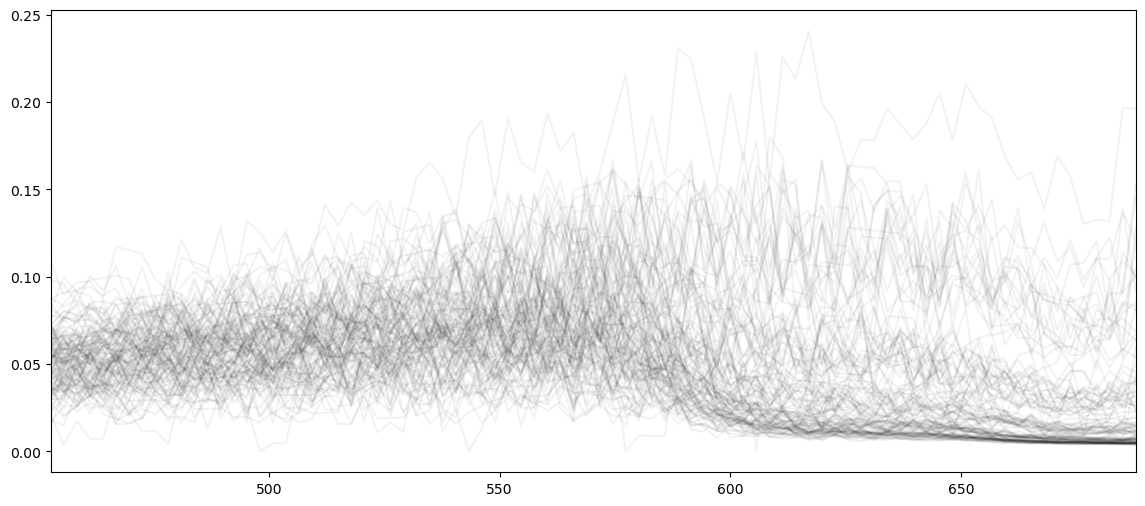

In [73]:
sim_spectra = frac_spectra
# select range of along diagonal: for different values of the various parameters
# Generate random indices for the first dimension (samples)
sample_indices = np.random.randint(0, sim_spectra.shape[0], size=(sim_spectra.shape[1], sim_spectra.shape[2], sim_spectra.shape[3], sim_spectra.shape[4]))

# Generate indices for depth, K, bb, and noise levels using np.ogrid
depth_indices, K_indices, bb_indices, noise_indices = np.ogrid[:sim_spectra.shape[1], :sim_spectra.shape[2], :sim_spectra.shape[3], :sim_spectra.shape[4]]

# Use advanced indexing to select one spectrum for each combination
selected_spectra = sim_spectra[sample_indices, depth_indices, K_indices, bb_indices, noise_indices]

fig, spectrum_ax = plt.subplots(figsize=(14, 6))

# plot example spectra spanning top three axes via gridspec
spectrum_ax.plot(wvs, selected_spectra.reshape(-1, selected_spectra.shape[-1]).T[:, ::9], color="k", alpha=0.05);
spectrum_ax.set_xlim(wvs.min(), wvs.max());


In [114]:
fitted_params = pd.DataFrame(fit.x.reshape(1, -1), columns=["bb", "K", "H"] + [f"Rb{i}" for i in range(len(endmember_array))])
fitted_params.values

array([[0.01376558, 0.0617502 , 7.51674328, 0.99555493, 0.99439239,
        0.011238  ]])

In [97]:
endmember_array = three_endmember_array

spread_sim_spectra, metadata = spectrum_utils.spread_simulate_spectra(
      wvs, endmember_array, AOP_args, Rb_vals = (1,1,0), N=100
)


i = 50
noise_level_ind = 9

# load in endmember data
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# endmember_bounds = (0, np.inf)
fit = minimize(
            spectrum_utils.r2_objective_fn,
            # spectrum_utils.spectral_angle_objective_fn,
            # initial parameter values
            x0=[0.1, 0.1, 0] + [0.0001] * len(endmember_array),
            # extra arguments passsed to the object function (and its derivatives)
            args=(spread_sim_spectra.iloc[i, :], # spectrum to fit (obs)
                  *AOP_args,    # wavelength-dependent backscatter and attenuation coefficients (bb_m, bb_c, Kd_m, Kd_c)
                  endmember_array  # typical end-member spectra
                  ),
            # constrain values
            # bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [endmember_bounds] * len(endmember_array),
            tol=1e-10,
            method='CG'
            ) # may not always want to constrain this (e.g. for PCs)

fitted_params = pd.DataFrame(fit.x.T, columns=["bb", "K", "H"] + [f"Rb{i}" for i in range(len(endmember_array))])
# fitted_spectrum = spectrum_utils.calc_fitted_spectrum(fit, wvs, endmember_array, AOP_args)
plotting.plot_single_fit(fitted_params, spread_sim_spectra.iloc[i, :], AOP_args, endmember_array, three_em_cats)

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Shape of passed values is (6, 1), indices imply (6, 6)

In [ ]:
endmember_array = three_endmember_array
cats = three_em_cats.keys()
# sim_spectra_df = pd.DataFrame(sim_spectra, columns=wvs)

noise_levels = np.linspace(0, 1e-3, 10)

dfs = {}
# for all example spectra, iterate over all noise levels
for n, nl in tqdm(enumerate(noise_levels), total=len(noise_levels)):
    spread_sim_spectra_df = pd.DataFrame(spread_sim_spectra[:50,n,:], columns=wvs)    
    partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.r2_objective_fn, prism_spectra=spread_sim_spectra_df, AOP_args=AOP_args, endmember_array=endmember_array, method="CG", tol=1e-10, bb_bounds=None, Kd_bounds=None, H_bounds=None)
    # partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.spectral_angle_objective_fn, prism_spectra=spread_sim_spectra_df, AOP_args=AOP_args, endmember_array=endmember_array, Rb_init=0.0001, method="L-BFGS-B", tol=1e-6)

    rerun=True
    # if rerun fitting process
    if rerun:
        with mp.Pool() as pool:
            result = list(tqdm(pool.imap(partial_wrapper, range(len(spread_sim_spectra_df))), total=len(spread_sim_spectra_df), leave=False))

        fits_df = pd.DataFrame(result, index=spread_sim_spectra_df.index, columns=['bb', 'K', 'H'] + list(cats))
    
    dfs[nl] = fits_df.iloc[:,3:]


In [ ]:
endmember_array = three_endmember_array
sim_spectra_df = pd.DataFrame(spread_sim_spectra[:,0,:], columns=wvs)
plt.plot(wvs, sim_spectra_df.values.T, color='k', alpha=0.01);

In [ ]:
from functools import partial
import multiprocess as mp

partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.r2_objective_fn, prism_spectra=sim_spectra_df, AOP_args=AOP_args, endmember_array=endmember_array, method="CG", tol=1e-10, bb_bounds=None, Kd_bounds=None, H_bounds=None)
# partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.spectral_angle_objective_fn, prism_spectra=sim_spectra_df, AOP_args=AOP_args, endmember_array=endmember_array, Rb_init=0.0001, method="L-BFGS-B", tol=1e-6)

rerun=True
# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(partial_wrapper, range(len(sim_spectra_df))), total=len(sim_spectra_df)))

    fits = pd.DataFrame(result, index=sim_spectra_df.index, columns=['bb', 'K', 'H'] + list(cats))
    # fits.to_csv('tmp/fits_avg_endmembers_new.csv')
# else load in values from tempfile
else:
    fits = pd.read_csv(file_ops.TMP_DIR_FP / "fits_avg_endmembers_new.csv", index_col=0)
    # fits = pd.read_csv('tmp/fits_avg_endmembers_og.csv', index_col=0) # original
    
fits.head()

In [ ]:
pred_spectra = spectrum_utils.generate_spectra_from_fits(fits, sim_spectra_df.columns, endmember_array, AOP_args)
metrics = spectrum_utils.calculate_metrics(sim_spectra_df, pred_spectra)
    
fig, ax = plt.subplots(2, 2, figsize=(12, 4), sharey=True)
ax[0,0].hist(metrics.r2, bins=50);
ax[0,0].set_yscale('log')
ax[0,0].set_title("r$^2$ overview")

min_r2 = 0.9
ax[0,1].hist(metrics.r2, bins=np.linspace(min_r2, 1, 50));
ax[0,1].set_title(f"r$^2$ > 0.9: {100*sum(metrics.r2 > min_r2)/len(metrics):.2f}%");

ax[1,0].hist(metrics.spectral_angle, bins=50);
ax[1,0].set_yscale('log')
ax[1,0].set_title("Spectral angle overview")

min_sa = 0.1
ax[1,1].hist(metrics.spectral_angle, bins=np.linspace(min_sa, 1, 50));
ax[1,1].set_title(f"Spectral angle < 0.1: {100*sum(metrics.spectral_angle < min_sa)/len(metrics):.2f}%");
plt.tight_layout()

In [ ]:
# Create a scatter plot of retrieved vs actual depth
scatter = go.Scatter(
    x=metadata.depth,
    y=fits.H,
    mode='markers',
    marker=dict(
        size=10,
        color=metrics.r2,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="whole-spectrum r<sup>2</sup> value"),
        line=dict(width=0.5, color='#000000'),
        opacity=0.5,
        # assign hover labels the respective values in metadata
        ),
        name='Data points',
        hovertext=[f"K: {K:.2f}, bb: {bb:.2f}, r<sup>2</sup>: {r2:.5f}, sa: {sa:.5f}, sample: {i}" for K, bb, r2, sa, i in zip(metadata.K, metadata.bb, metrics.r2, metrics.spectral_angle, metadata.index)],
    # hoverinfo="text"
)

p = np.polyfit(metadata.depth, fits.H, 1)
pred = np.polyval(p, metadata.depth)
# THIS LOOKS WRONG
best_fit_line = go.Scatter(
    x=metadata.depth,
    y=pred,
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f"Best fit: {p[0]:.2f}x + {p[1]:.2f}",
)
one_to_one_line = go.Scatter(
    x=[min(metadata.depth), max(metadata.depth)],
    y=[min(metadata.depth), max(metadata.depth)],
    mode='lines',
    line=dict(color='black'),
    name='1:1'
)

plot = True
if plot:
    fig = make_subplots()
    fig.add_trace(scatter)
    fig.add_trace(best_fit_line)
    fig.add_trace(one_to_one_line)

    # Update layout
    fig.update_layout(
        title=f"r<sup>2</sup>: {r2_score(metadata.depth, fits.H):.5f}",
        xaxis_title="True depth (m)",
        yaxis_title="Retrieved depth (m)",
        xaxis=dict(range=[min(metadata.depth), max(metadata.depth)], scaleanchor='y', scaleratio=1),
        yaxis=dict(range=[min(metadata.depth), max(metadata.depth)], scaleanchor='x', scaleratio=1),
        legend=dict(x=0.02, y=0.98),   
    )

    fig.update_yaxes(
        scaleanchor='x',
        scaleratio=1,
    )

    # show the figure
    fig.show()

In [ ]:
r2_threshold = 0.9
sa_threshold = 0.01

metadata['r2'] = np.nan
metadata['spectral_angle'] = np.nan

for i, row in tqdm(fits.iterrows(), total=len(fits)):
    bb_m, bb_c, Kd_m, Kd_c = AOP_args
    bb, K, H = row.values[:3]
    pred = spectrum_utils.sub_surface_reflectance_Rb(sim_spectra_df.columns, endmember_array, bb, K, H, AOP_args, *row.values[3:])
    metadata.loc[i, 'r2'] = r2_score(sim_spectra_df.loc[i], pred)
    metadata.loc[i, 'spectral_angle'] = spectrum_utils.spectral_angle(sim_spectra_df.loc[i], pred)
    
def plot_good_bad_fits(ax, metric: str="r2", bad_fit_range: tuple[float, float]=[0,0.1], metric_name: str="r$^2$"):
    bad_inds = (metadata[metric] < max(bad_fit_range)) & (metadata[metric] > min(bad_fit_range))
    bad_fits = metadata[bad_inds]
    good_fits = metadata[~bad_inds]
    
    ax.plot(sim_spectra_df.columns, sim_spectra_df.loc[bad_fits.index].values.T, color='red', lw=0.6)
    ax.plot(sim_spectra_df.columns, sim_spectra_df.loc[good_fits.index].values.T, color='k', alpha=0.1, lw=0.6, zorder=-2)
    ax.plot([], [], color="red", lw=0.6, label=f"bad fits: {min(bad_fit_range)} < {metric_name} < {max(bad_fit_range)}")
    ax.set_title(f'Fitted simulated spectra (Rb + water column effects)\nNumber of bad fits: {bad_fits.shape[0]} (of {len(fits)})')
    ax.set_xlim(sim_spectra_df.columns.min(), sim_spectra_df.columns.max())
    ax.legend()
    return ax
    
    
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax_r2 = plot_good_bad_fits(axes[0], "r2", [0, 0.98], "r$^2$")
ax_sa = plot_good_bad_fits(axes[1], "spectral_angle", [0.01, np.inf], "spectral angle")
plt.tight_layout()


# Simulating received spectra

In [8]:
# load features (spectra)
raw_spectra = spectrum_utils.load_spectra()
validation_spectra = spectrum_utils.preprocess_prism_spectra(raw_spectra, spectrum_utils.NIR_WAVELENGTHS, spectrum_utils.SENSOR_RANGE)

In [10]:
g_cfg, run_cfg = file_ops.instantiate_single_configs_instance(run_ind = 0)

run_cfg.simulation['N'] = 1000
sims = optimisation_pipeline.SimulateSpectra(g_cfg, run_cfg).generate_simulated_spectra()

import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add traces for each spectrum
for i in range(sims.shape[0]):
    fig.add_trace(go.Scatter(
        x=sims.columns[4:],  # Wavelengths
        y=sims.iloc[i, 4:],  # Spectra values
        mode='lines',
        line=dict(color='black', width=1),
        opacity=0.05,
        hoverinfo='text',
        text=f"Depth: {sims.iloc[i]['depth']:.2f}, K: {sims.iloc[i]['K']:.2f}, bb: {sims.iloc[i]['bb']:.2f}"
    ))

# Update layout
fig.update_layout(
    title="Simulated Spectra",
    xaxis_title="Wavelength (nm)",
    yaxis_title="Reflectance",
    showlegend=False,
    width=1400,
    height=600,
    yaxis=dict(range=[0, max(validation_spectra.T.max())]),
)

# Show the figure
fig.show()

Generating simulated spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

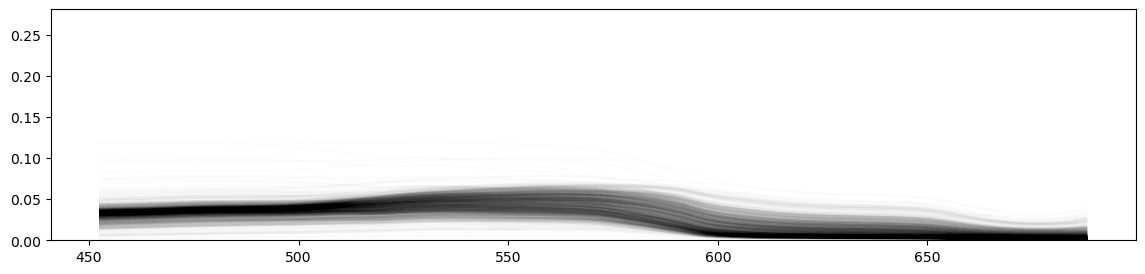

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.plot(sims.iloc[:,4:].T, alpha=0.01, c='k');
ax.set_ylim(0, np.max(validation_spectra.T.max()));

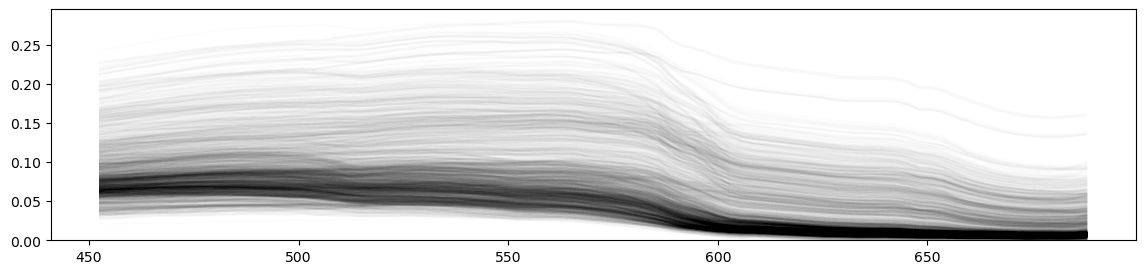

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.plot(validation_spectra.T, alpha=0.01, c='k');
ax.set_ylim(0);

In [13]:
fit_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/results/fits/fit_results_1.csv"
fits = pd.read_csv(fit_fp, header=[0,1])
fitted_spectra = fits.fitted_spectra
fitted_spectra.columns = fitted_spectra.columns.astype(float)

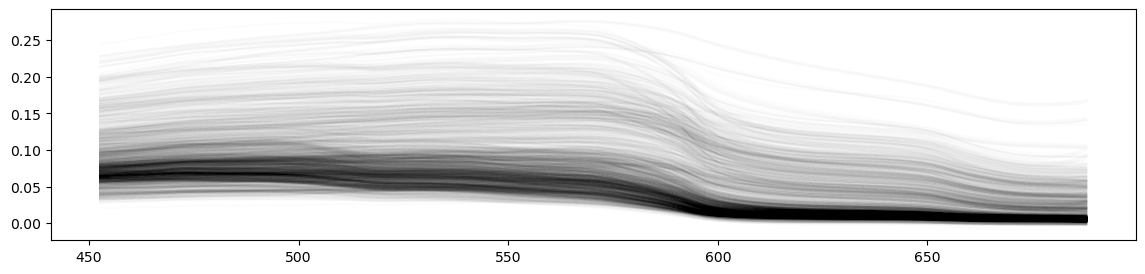

In [14]:
# plot example (good) fits
fit_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/results/fits/fit_results_1.csv"
fits = pd.read_csv(fit_fp, header=[0,1])
fits.fitted_params.head()
fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.plot(fits.fitted_spectra.columns.astype('float'), fits.fitted_spectra.T, alpha=0.01, c='k');

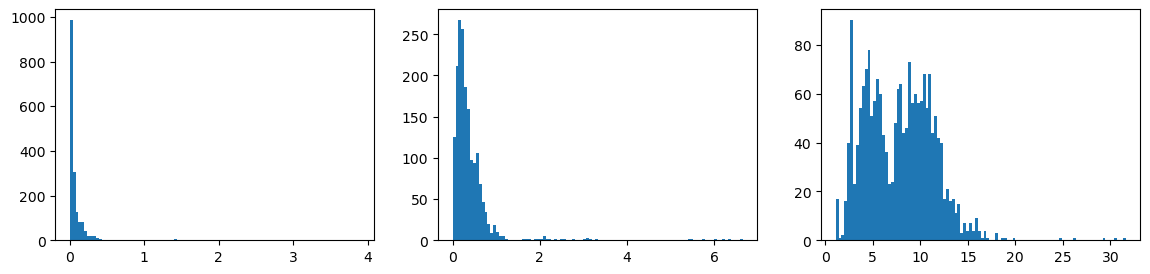

In [15]:
fig, ax = plt.subplots(1,3, figsize=(14,3))
# crop out values below 0
bb_vals = fits[fits.fitted_params.bb > 0]
K_vals = fits[fits.fitted_params.K > 0]
H_vals = fits[fits.fitted_params.H > 0]

ax[0].hist(bb_vals.fitted_params.bb, bins=100);
ax[1].hist(K_vals.fitted_params.K, bins=100);
ax[2].hist(H_vals.fitted_params.H, bins=100);

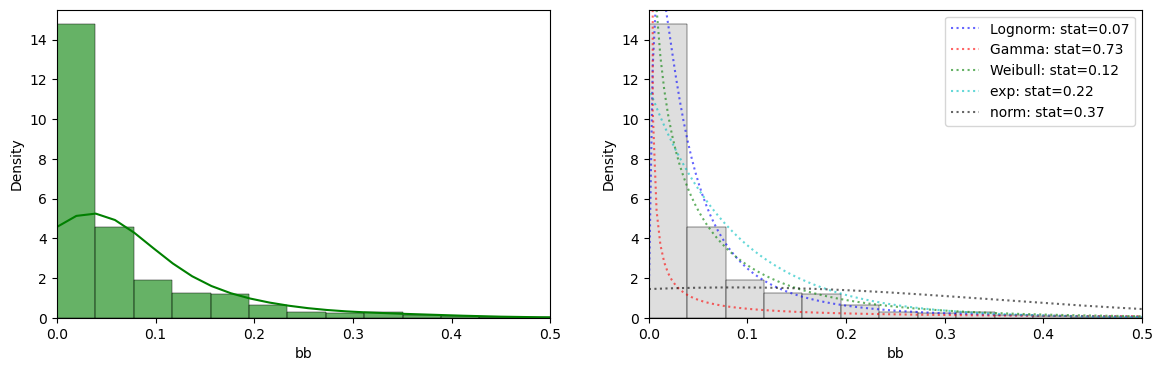

In [16]:
def fit_plot_distribution(data, xlims: tuple[float, float]=None, N_bins: int = 100):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    hist = sns.histplot(data, bins=N_bins, stat="density", alpha=0.6, color='g', kde=True, ax=axes[0]) 
    # fit distributions to bb and K
    shape, loc_lognorm, scale_lognorm = stats.lognorm.fit(data)
    lognorm_pdf = stats.lognorm.pdf(np.linspace(min(data), max(data), 1000), shape, loc=loc_lognorm, scale=scale_lognorm)

    alpha, loc_gamma, beta_gamma = stats.gamma.fit(data)
    gamma_pdf = stats.gamma.pdf(np.linspace(min(data), max(data), 1000), alpha, loc=loc_gamma, scale=beta_gamma)

    c_weibull_min, loc_weibull_min, scale_weibull_min = stats.weibull_min.fit(data)
    weibull_pdf = stats.weibull_min.pdf(np.linspace(min(data), max(data), 1000), c_weibull_min, loc=loc_weibull_min, scale=scale_weibull_min)
    
    # exponential fit
    loc_exp, scale_exp = stats.expon.fit(data)
    exp_pdf = stats.expon.pdf(np.linspace(min(data), max(data), 1000), loc=loc_exp, scale=scale_exp)
    
    # normal fit
    loc_norm, scale_norm = stats.norm.fit(data)
    norm_pdf = stats.norm.pdf(np.linspace(min(data), max(data), 1000), loc=loc_norm, scale=scale_norm)

    lognorm_ks = stats.kstest(data, 'lognorm', args=(shape, loc_lognorm, scale_lognorm))
    gamma_ks = stats.kstest(data, 'gamma', args=(alpha, loc_gamma, beta_gamma))
    weibull_ks = stats.kstest(data, 'weibull_min', args=(c_weibull_min, loc_weibull_min, scale_weibull_min))
    exp_ks = stats.kstest(data, 'expon', args=(loc_exp, scale_exp))
    norm_ks = stats.kstest(data, 'norm', args=(loc_norm, scale_norm))

    x = np.linspace(min(data), max(data), 1000)
    sns.histplot(data, bins=N_bins, kde=False, stat='density', color='lightgray')
    # fig.suptitle([(f"{dist} {stat}: {getattr(ks, stat):.2f}\n") for dist, ks in zip(["Log-normal", "Gamma", "Weibull"], [lognorm_ks, gamma_ks, weibull_ks]) for stat in ["statistic", "pvalue"]])
    axes[1].plot(x, lognorm_pdf, label=f"Lognorm: stat={lognorm_ks.statistic:.02f}", color='blue', alpha=0.6, ls=":")
    axes[1].plot(x, gamma_pdf, label=f"Gamma: stat={gamma_ks.statistic:.02f}", color='red', alpha=0.6, ls=":")
    axes[1].plot(x, weibull_pdf, label=f"Weibull: stat={weibull_ks.statistic:.02f}", color='green', alpha=0.6, ls=":")
    axes[1].plot(x, exp_pdf, label=f"exp: stat={exp_ks.statistic:.02f}", color='c', alpha=0.6, ls=":")
    axes[1].plot(x, norm_pdf, label=f"norm: stat={norm_ks.statistic:.02f}", color='k', alpha=0.6, ls=":")
    axes[1].legend()
    axes[1].set_ylim(0, np.max(hist.get_ylim()))
    [ax.set_xlim(xlims) for ax in axes] if xlims else None
    
    best_pdf = [lognorm_pdf, gamma_pdf, weibull_pdf, exp_pdf, norm_pdf][np.argmin([lognorm_ks.statistic, gamma_ks.statistic, weibull_ks.statistic, exp_ks.statistic, norm_ks.statistic])]
    if best_pdf[0] > 100:
        best_pdf[0] = best_pdf[1]
    
    return best_pdf
    
    
from scipy import stats
best_pdf_bb = fit_plot_distribution(bb_vals.fitted_params.bb, 
                                    xlims = (0,0.5)
                                    )
# save pdf to numpy array
np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "bb_pdf.npy", best_pdf_bb)

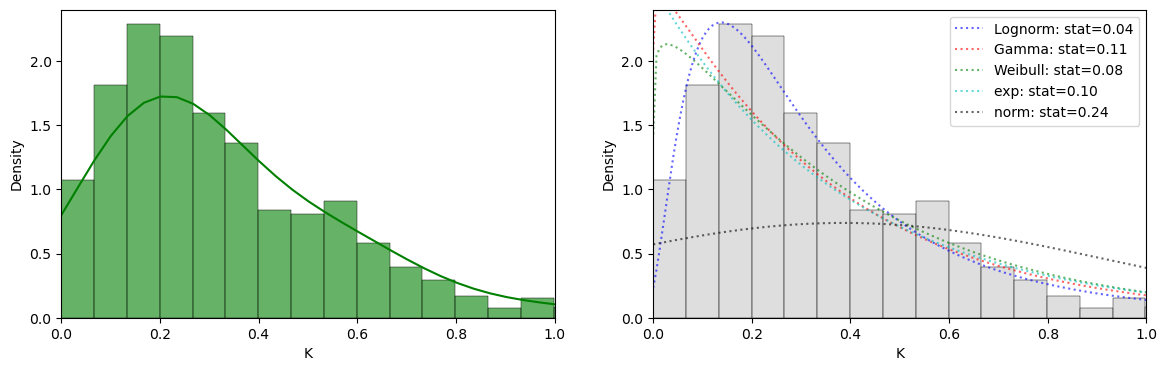

In [17]:
best_pdf_k = fit_plot_distribution(K_vals.fitted_params.K,
                                xlims = (0,1)
                            )
np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "k_pdf.npy", best_pdf_k)

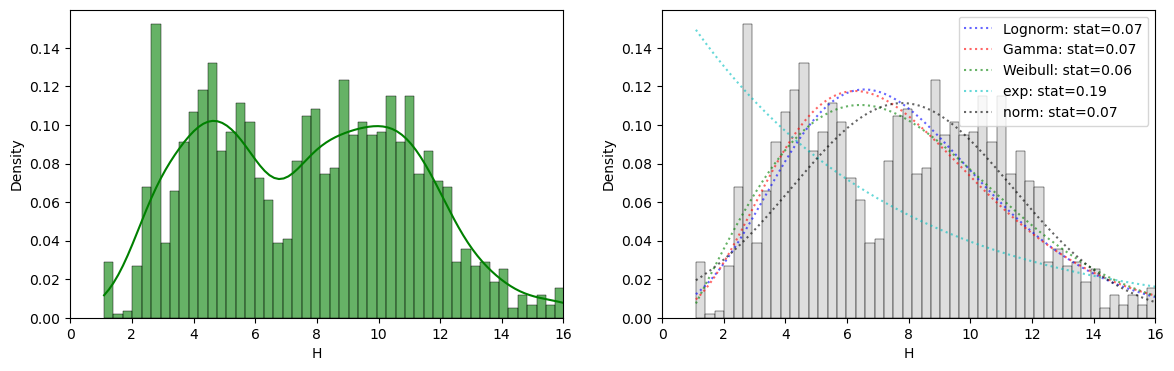

In [18]:
best_pdf_H = fit_plot_distribution(H_vals.fitted_params.H,
                                                                     xlims = (0,16)
                                                                     )

Fitted parameters: mu1=4.857933219960655, sigma1=1.4804333399628313, mu2=10.147956934312184, sigma2=1.9616503919901633, p=0.3810192799437988


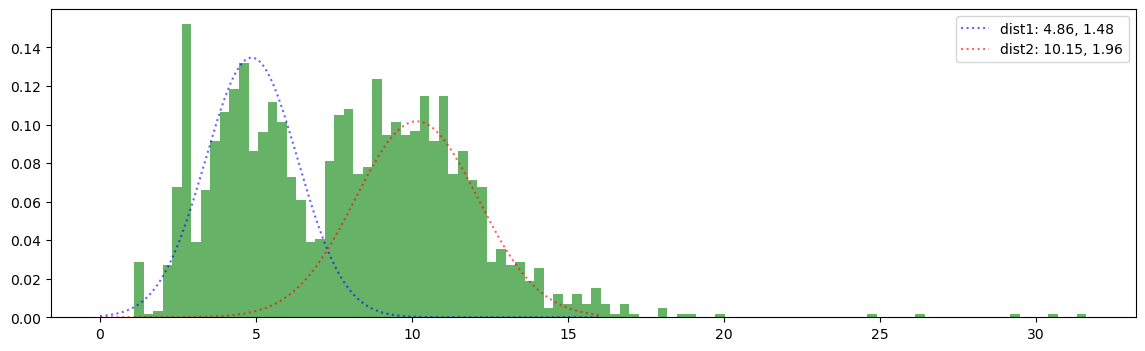

In [20]:
from scipy.optimize import minimize
from scipy.stats import norm

def neg_log_likelihood(params, data):
    mu1, sigma1, mu2, sigma2, p = params
    dist1 = norm(mu1, sigma1)
    dist2 = norm(mu2, sigma2)
    
    mixture_pdf = p * dist1.pdf(data) + (1 - p) * dist2.pdf(data)
    eps = 1e-10  # Small epsilon to prevent log(0)
    return -np.sum(np.log(mixture_pdf + eps))

# initial guesses
params = [5, 1, 10, 1, 0.5]

# bounds to ensure sigma > 0 and 0 <= p <= 1
bounds = [(-np.inf, np.inf), (1e-3, np.inf),  # mu1, sigma1
          (-np.inf, np.inf), (1e-3, np.inf),  # mu2, sigma2
          (0, 1)]                             # p (mixture proportion)

H_vals_array = H_vals.fitted_params.H.values
res = minimize(neg_log_likelihood, params, args=(H_vals_array,), bounds=bounds, tol=1e-2)   # only works with low tolerance

if res.success:
    mu1, sigma1, mu2, sigma2, p = res.x
    print(f"Fitted parameters: mu1={mu1}, sigma1={sigma1}, mu2={mu2}, sigma2={sigma2}, p={p}")
else:
    print("Optimization failed:", res.message)

# plotting
x = np.linspace(0, 16, 1000)
dist1 = norm(mu1, sigma1)
dist2 = norm(mu2, sigma2)
pdf1 = dist1.pdf(x) / 2
pdf2 = dist2.pdf(x) / 2

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.hist(H_vals_array, bins=100, density=True, alpha=0.6, color='g')

ax.plot(x, pdf1, label=f"dist1: {mu1:.2f}, {sigma1:.2f}", color='blue', alpha=0.6, ls=":")
ax.plot(x, pdf2, label=f"dist2: {mu2:.2f}, {sigma2:.2f}", color='red', alpha=0.6, ls=":")
ax.legend()
plt.show()


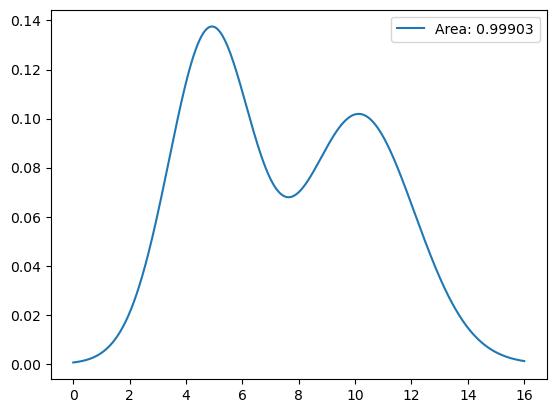

In [21]:
from scipy.integrate import simpson
# combine pdfs
pdf_H = pdf1 + pdf2
plt.plot(x, pdf_H, label=f"Area: {simpson(pdf_H, x=x):.5f}")
plt.legend()
# save pdf to numpy array
np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "H_pdf.npy", pdf_H)

Fitted parameters: mu1=4.992718473976953, sigma1=0.9950379992764253, mu2=10.018311936053312, sigma2=0.9951060431939519, p=0.49989343672047215


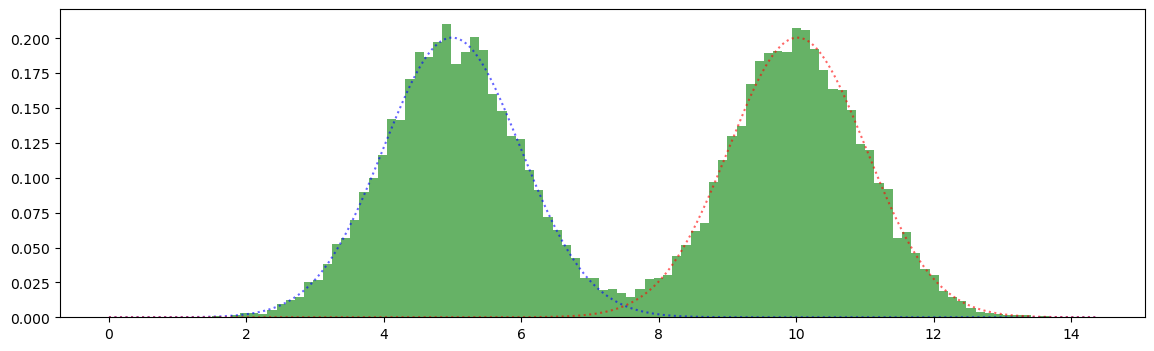

In [22]:
m1, m2, s1, s2 = 5,10,1,1
test_data = np.concatenate([np.random.normal(m1, s1, 10000), np.random.normal(m2, s2, 10000)])

res = minimize(neg_log_likelihood, params, args=(test_data,), bounds=bounds)

# Check if optimization succeeded
if res.success:
    mu1, sigma1, mu2, sigma2, p = res.x
    print(f"Fitted parameters: mu1={mu1}, sigma1={sigma1}, mu2={mu2}, sigma2={sigma2}, p={p}")
else:
    print("Optimization failed:", res.message)
    
# Plot the fitted distributions
x = np.linspace(0, test_data.max(), 1000)
dist1 = norm(mu1, sigma1)
dist2 = norm(mu2, sigma2)
pdf1 = dist1.pdf(x) / 2 # scale since bimodal
pdf2 = dist2.pdf(x) / 2


fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.hist(test_data, bins=100, density=True, alpha=0.6, color='g')
ax.plot(x, pdf1, label=f"dist1: {mu1:.2f}, {sigma1:.2f}", color='blue', alpha=0.6, ls=":")
ax.plot(x, pdf2, label=f"dist2: {mu2:.2f}, {sigma2:.2f}", color='red', alpha=0.6, ls=":")


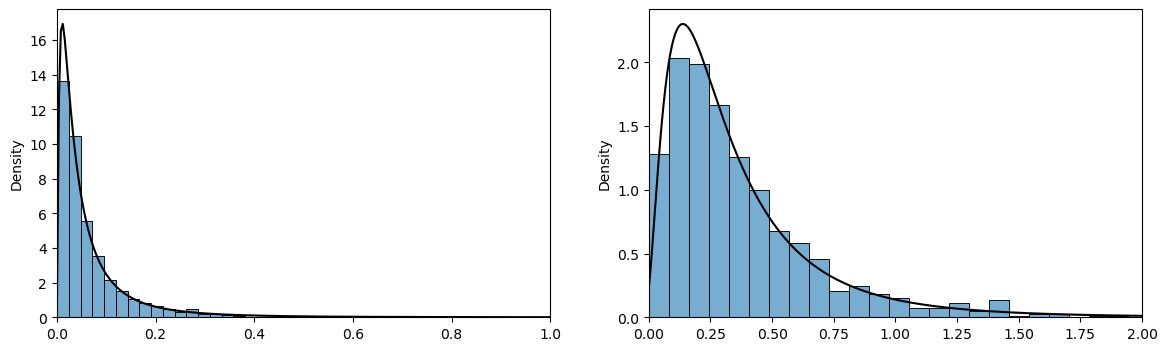

In [23]:
N_samples = 1000
f, axes = plt.subplots(1,2, figsize=(14, 4))
bb_sampling = np.random.choice(
    np.linspace(0, np.max(bb_vals.fitted_params.bb), N_samples), size=N_samples, p=best_pdf_bb / np.sum(best_pdf_bb)
)
sns.histplot(bb_sampling, bins=50, stat="density", alpha=0.6, ax=axes[0]) 
axes[0].plot(np.linspace(0, np.max(bb_vals.fitted_params.bb), N_samples), best_pdf_bb, c="k", label="Exponential pdf")
axes[0].set_xlim(0,1)

k_sampling = np.random.choice(
    np.linspace(0, np.max(K_vals.fitted_params.K), N_samples), size=N_samples, p=best_pdf_k / np.sum(best_pdf_k)
)
sns.histplot(k_sampling, bins=50, stat="density", alpha=0.6, ax=axes[1])
axes[1].plot(np.linspace(0, np.max(K_vals.fitted_params.K), N_samples), best_pdf_k, c="k", label="Log-normal pdf")
axes[1].set_xlim(0,2)

# save sampling distributions to numpy
np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "bb_sampling.npy", bb_sampling)
np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "k_sampling.npy", k_sampling)

In [24]:
# RBs!!!
# load in validation data
validation_data = pd.read_csv(
            file_ops.DATA_DIR_FP / "CORAL_validation_data.csv"
        )
validation_data = spectrum_utils.map_validation(validation_data, g_cfg.__dict__["endmember_map"])
endmember_class_schema = "three_endmember"
endmember_schema_map = g_cfg.__dict__["endmember_schema"][endmember_class_schema]
grouped_val_data = pd.DataFrame()
# group validation data by endmember categories in endmember_schema_map
for (endmember_dimensionality_reduction, validation_fields) in endmember_schema_map.items():
    # fill in validation data with sum of all fields in the category
    grouped_val_data[endmember_dimensionality_reduction] = validation_data[
        validation_fields
    ].sum(axis=1)
    
# normalise grouped_val_data along rows
grouped_val_data = grouped_val_data.div(grouped_val_data.sum(axis=1), axis=0)
grouped_val_data.drop_duplicates()

algae     coral      sand
0     0.720000  0.010000  0.270000
9     0.904255  0.042553  0.053191
18    0.313131  0.080808  0.606061
26    0.530000  0.010000  0.460000
35    0.767677  0.181818  0.050505
...        ...       ...       ...
1912  0.590000  0.380000  0.030000
1916  0.272727  0.727273  0.000000
1919  0.535354  0.444444  0.020202
1932  0.602041  0.367347  0.030612
1935  0.505051  0.484848  0.010101

[191 rows x 3 columns]

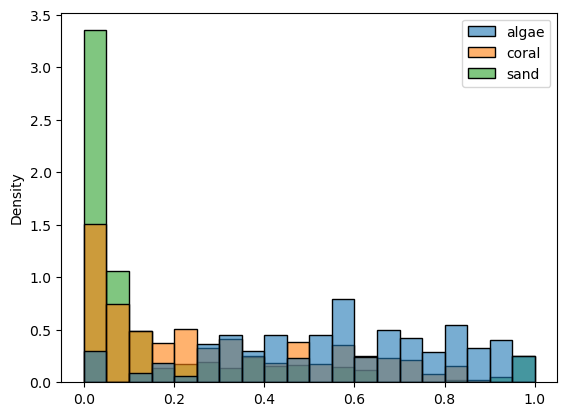

In [25]:
sns.histplot(grouped_val_data, bins=20, stat="density", alpha=0.6);

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning:

overflow encountered in divide

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

overflow encountered in reduce

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning:

overflow encountered in divide



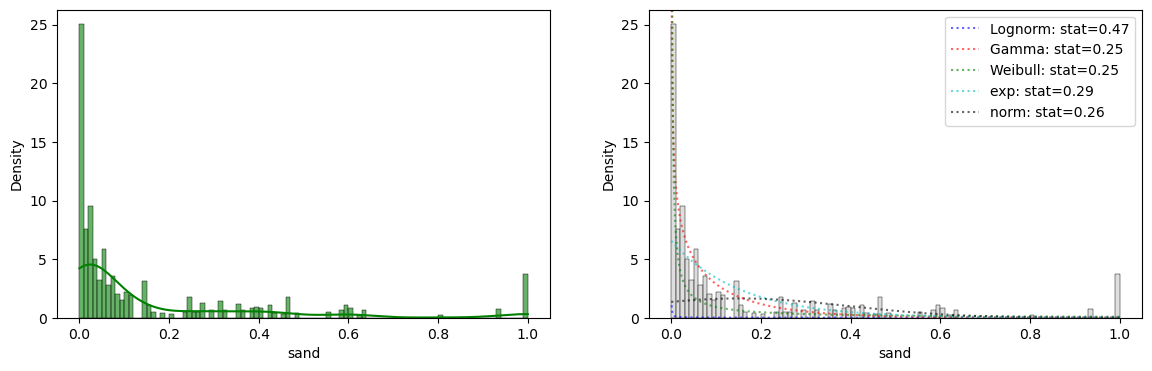

In [26]:
best_pdf_sand = fit_plot_distribution(grouped_val_data.sand
                                                                    #  xlims = (0,0.5)
                                                                     )
np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "sand_pdf.npy", best_pdf_sand)

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning:

overflow encountered in divide

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

overflow encountered in reduce

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning:

overflow encountered in divide

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning:

overflow encountered in divide

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

overflow encountered in reduce

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2036: RuntimeWarning:

overflow encountered in divide



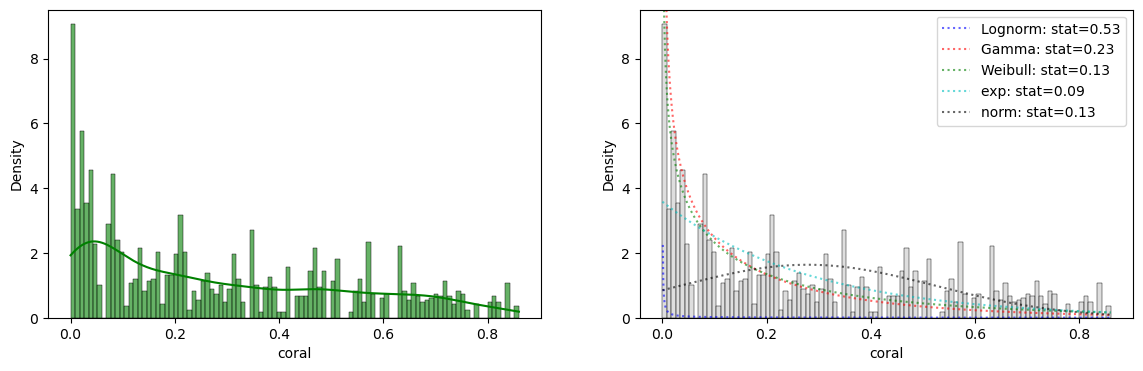

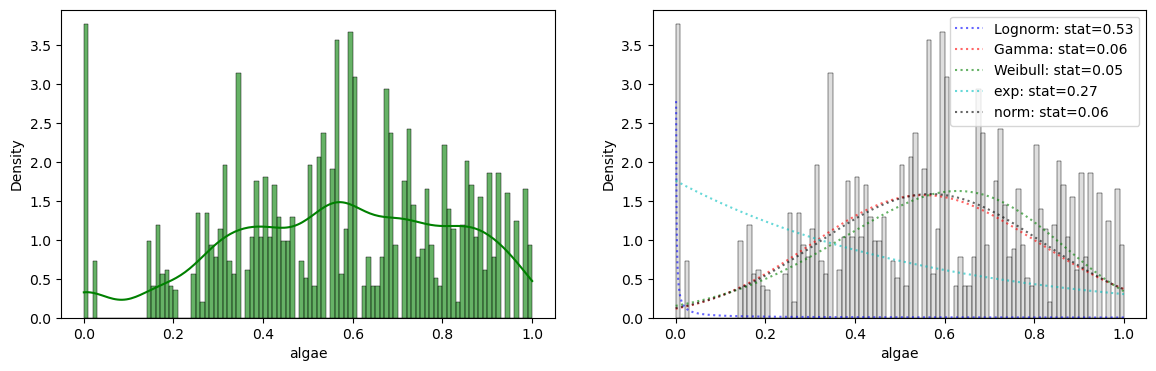

In [28]:
best_pdf_coral = fit_plot_distribution(grouped_val_data.coral
                                                                    #  xlims = (0,0.5)
                                                                     )
# np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "coral_pdf.npy", best_pdf_coral)

best_pdf_algae = fit_plot_distribution(grouped_val_data.algae
                                                                    #  xlims = (0,0.5)
                                                                     )
# np.save(file_ops.RESOURCES_DIR_FP / "distributions" / "algae_pdf.npy", best_pdf_algae)


# Recreate scene spectra

In [37]:
from scipy.stats import rv_continuous, norm
import numpy as np

def sample_from_pdf(pdf, n_samples):
    """
    Sample from a given probability distribution function (PDF).
    """
    # Create a grid of indices corresponding to the PDF
    x = np.arange(len(pdf))
    
    # Normalize the PDF to sum to 1 (if not already normalized)
    pdf_normalized = pdf / pdf.sum()

    # Use np.random.choice to sample indices based on the PDF
    sampled_indices = np.random.choice(x, size=n_samples, p=pdf_normalized)

    return sampled_indices

def generate_fractional_cover_from_pdfs(n_samples, algae_pdf, coral_pdf, sand_pdf):
    # Sample from each PDF
    algae_samples = sample_from_pdf(algae_pdf, n_samples)
    coral_samples = sample_from_pdf(coral_pdf, n_samples)
    sand_samples = sample_from_pdf(sand_pdf, n_samples)

    # Stack the sampled values
    samples = np.vstack([algae_samples, coral_samples, sand_samples]).T

    # Normalize the samples to ensure they sum to 1
    samples = samples / samples.sum(axis=1, keepdims=True)

    return samples

n_samples = 10
fractional_covers = generate_fractional_cover_from_pdfs(n_samples, best_pdf_algae, best_pdf_coral, best_pdf_sand)

g_cfg, run_cfg = file_ops.instantiate_single_configs_instance(run_ind = 1)


from tqdm.auto import tqdm
sims_dfs = []
for Rb_vals in tqdm(fractional_covers):
    run_cfg.simulation["Rb_vals"] = Rb_vals
    sims = optimisation_pipeline.SimulateSpectra(g_cfg, run_cfg).generate_simulated_spectra()
    sims_dfs.append(sims)

# concatenate all dataframes
sim_df = pd.concat(sims_dfs)

  0%|          | 0/10 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
sim_df

depth         K        bb  noise  452.642775  455.475056  458.307394  \
0    4.036036  0.326422  0.030873      0    0.049883    0.050547    0.051112   
1    3.481081  0.042149  0.026345      0    0.059988    0.060574    0.061027   
2    5.280480  0.219030  0.004116      0    0.041783    0.042430    0.042976   
3    7.029429  0.146382  0.002470      0    0.042045    0.042645    0.043146   
4   10.863664  0.086369  0.010291      0    0.050094    0.050570    0.050957   
..        ...       ...       ...    ...         ...         ...         ...   
95   7.113514  0.073735  0.000412      0    0.041334    0.041762    0.042088   
96   5.869069  0.108479  0.013173      0    0.047702    0.048140    0.048474   
97  10.645045  0.222188  0.003293      0    0.029718    0.030177    0.030574   
98  11.334535  0.111638  0.020582      0    0.053892    0.054235    0.054504   
99  10.678679  0.045307  0.012761      0    0.053135    0.053427    0.053629   

    461.139788  463.972238  466.804744  ...  662.383497  665.21994  \
0     0.051672    0.052268    0.052946  ...    0.019725   0.018001   
1     0.061471    0.061967    0.062577  ...    0.026986   0.024539   
2     0.043526    0.044119    0.044795  ...    0.010513   0.009388   
3     0.043668    0.044239    0.044894  ...    0.005830   0.005194   
4     0.051408    0.051922    0.052518  ...    0.003760   0.003538   
..         ...         ...         ...  ...         ...        ...   
95    0.042466    0.042946    0.043577  ...    0.005603   0.004912   
96    0.048853    0.049330    0.049956  ...    0.010601   0.009517   
97    0.031026    0.031546    0.032157  ...    0.002248   0.002077   
98    0.054865    0.055322    0.055897  ...    0.005351   0.005112   
99    0.053927    0.054339    0.054896  ...    0.004383   0.004119   

    668.056439  670.892995  673.729607  676.566275  679.402999  682.239779  \
0     0.016593    0.015544    0.014888    0.014559    0.014493    0.014671   
1     0.022521    0.021010    0.020057    0.019585    0.019530    0.019886   
2     0.008482    0.007813    0.007395    0.007175    0.007105    0.007162   
3     0.004689    0.004317    0.004081    0.003946    0.003875    0.003846   
4     0.003362    0.003226    0.003134    0.003067    0.003004    0.002932   
..         ...         ...         ...         ...         ...         ...   
95    0.004372    0.003982    0.003743    0.003618    0.003571    0.003586   
96    0.008655    0.008026    0.007639    0.007439    0.007377    0.007433   
97    0.001946    0.001849    0.001788    0.001748    0.001717    0.001686   
98    0.004921    0.004771    0.004666    0.004584    0.004503    0.004405   
99    0.003911    0.003753    0.003647    0.003570    0.003502    0.003426   

    685.076616  687.913509  
0     0.015116    0.015797  
1     0.020687    0.021864  
2     0.007347    0.007629  
3     0.003856    0.003884  
4     0.002850    0.002751  
..         ...         ...  
95    0.003659    0.003760  
96    0.007607    0.007861  
97    0.001653    0.001614  
98    0.004289    0.004150  
99    0.003340    0.003236  

[1000 rows x 88 columns]

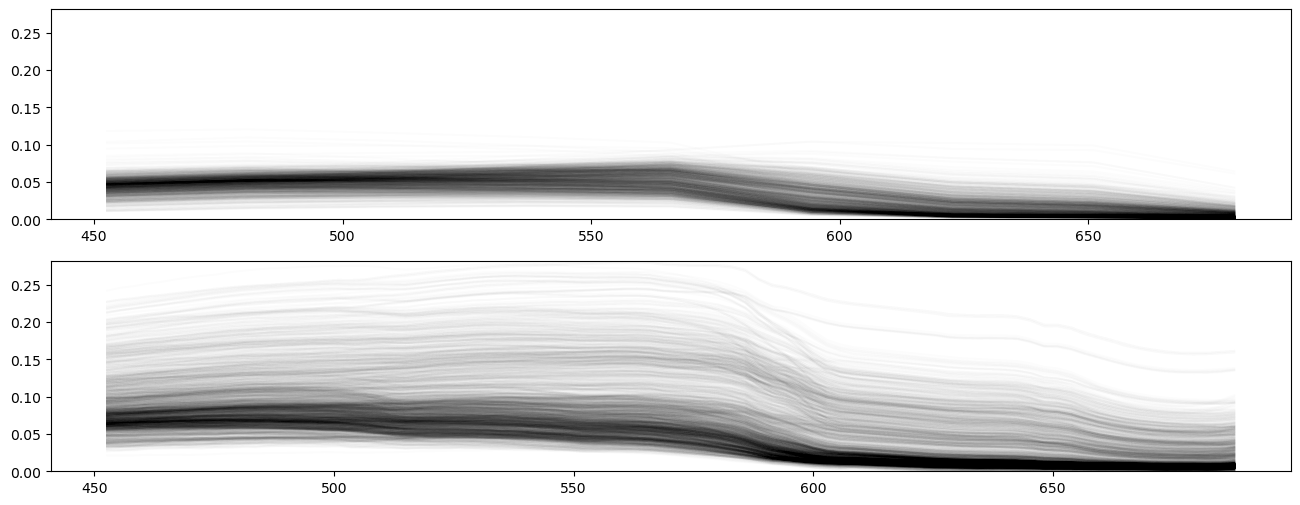

In [39]:
ylim = max(np.max(sim_df.iloc[:,4:]), np.max(validation_spectra))
fig, ax = plt.subplots(2, 1, figsize=(16,6))
sim_df = pd.concat([sim_df for sim_df in sims_dfs])
ax[0].plot(sim_df.iloc[:,4:].T[::10], alpha=0.01, c='k');
ax[1].plot(validation_spectra.T, alpha=0.01, c='k');

[a.set_ylim(0, ylim) for a in ax];

In [66]:
# # save pd
# labels_df = pd.DataFrame(fractional_covers, columns=["algae", "coral", "sand"])
# with open(file_ops.TMP_DIR_FP / "labels_df.pkl", "wb") as f:
#     pickle.dump(labels_df, f)

In [65]:
# # for now, saving
# import pickle

# with open(file_ops.TMP_DIR_FP / "sims_df.pkl", "wb") as f:
#     pickle.dump(sim_df, f)

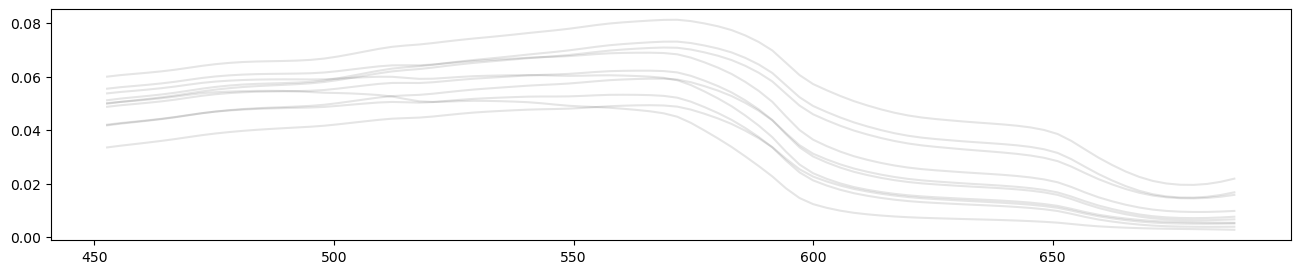

In [40]:

fig, ax = plt.subplots(1, 1, figsize=(16,3))
ax.plot(sim_df.iloc[:,4:].T.iloc[:,:10], alpha=0.1, c='k');

In [44]:
from reflectance import ml_utils
# train RF on simulated data
(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="simulation").generate_data()
print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

N train samples: 1600
N features: 84
N test samples: 400
Label dimensions: 3


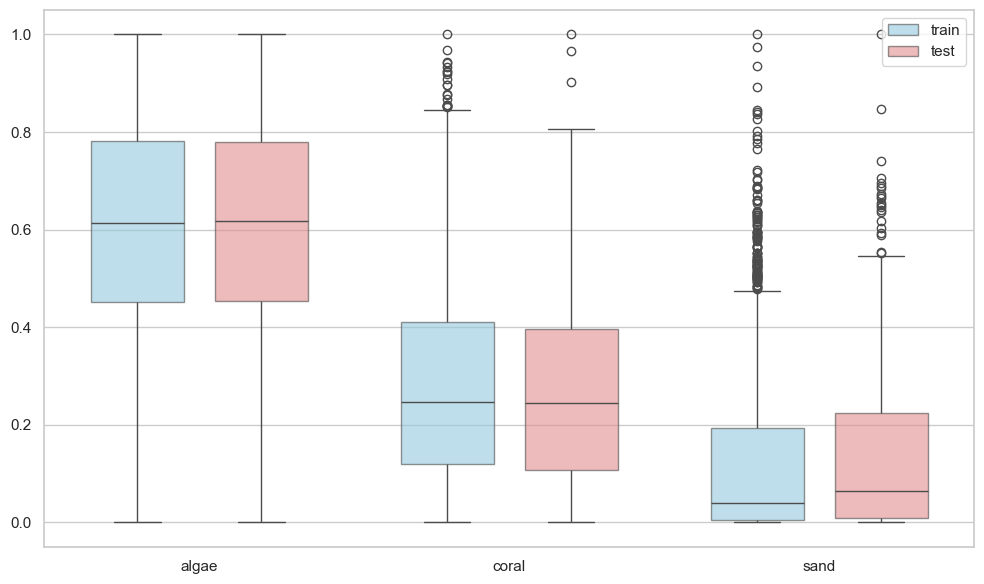

In [45]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=y_train, ax=ax, positions=np.arange(len(y_train.columns)) - 0.2, width=0.3, color="skyblue", boxprops=dict(alpha=0.6), label="train")
sns.boxplot(data=y_test, ax=ax, positions=np.arange(len(y_test.columns)) + 0.2, width=0.3, color="lightcoral", boxprops=dict(alpha=0.6), label="test")

plt.legend()
plt.tight_layout()

In [51]:
# best_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=10).return_fitted_model(X_train, y_train)
# best_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=100).return_fitted_model(X_train, y_train)
best_mlp = ml_utils.sklModels(model_type="mlp", n_iter_search=50).return_fitted_model(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't conv

RandomizedSearchCV took 291.11 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.947 (std: 0.021)
Parameters: {'tol': 1e-09, 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'tanh'}
Model with rank: 2
Mean validation score: 0.944 (std: 0.012)
Parameters: {'tol': 1e-09, 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'activation': 'tanh'}
Model with rank: 3
Mean validation score: 0.937 (std: 0.030)
Parameters: {'tol': 1e-09, 'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.0001, 'activation': 'tanh'}


In [47]:
y_train

algae     coral      sand
968   0.781869  0.015183  0.219227
240   0.830834  0.079811  0.099874
819   0.891713  0.084033  0.030378
692   0.961324  0.030176  0.011727
420   0.461901  0.076323  0.498135
...        ...       ...       ...
1130  0.764872  0.117153  0.131737
1294  0.512555  0.487664  0.017680
860   0.801850  0.204801  0.001352
1459  0.586943  0.426063  0.001945
1126  0.664054  0.348343  0.000000

[1600 rows x 3 columns]

In [77]:
# permute columns [1,0,2]
y_train = y_train.iloc[:, [1,0,2]]

In [48]:
# predict
fitted_rf = best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R^2 for RandomForest: {r2_rf:.3f}")

R^2 for RandomForest: 0.381


(<Figure size 1800x900 with 3 Axes>,
 array([<Axes: title={'center': '$r^2$ = 0.36\nN = 399'}>,
        <Axes: title={'center': '$r^2$ = 0.59\nN = 399'}>,
        <Axes: title={'center': '$r^2$ = 0.20\nN = 368'}>], dtype=object))

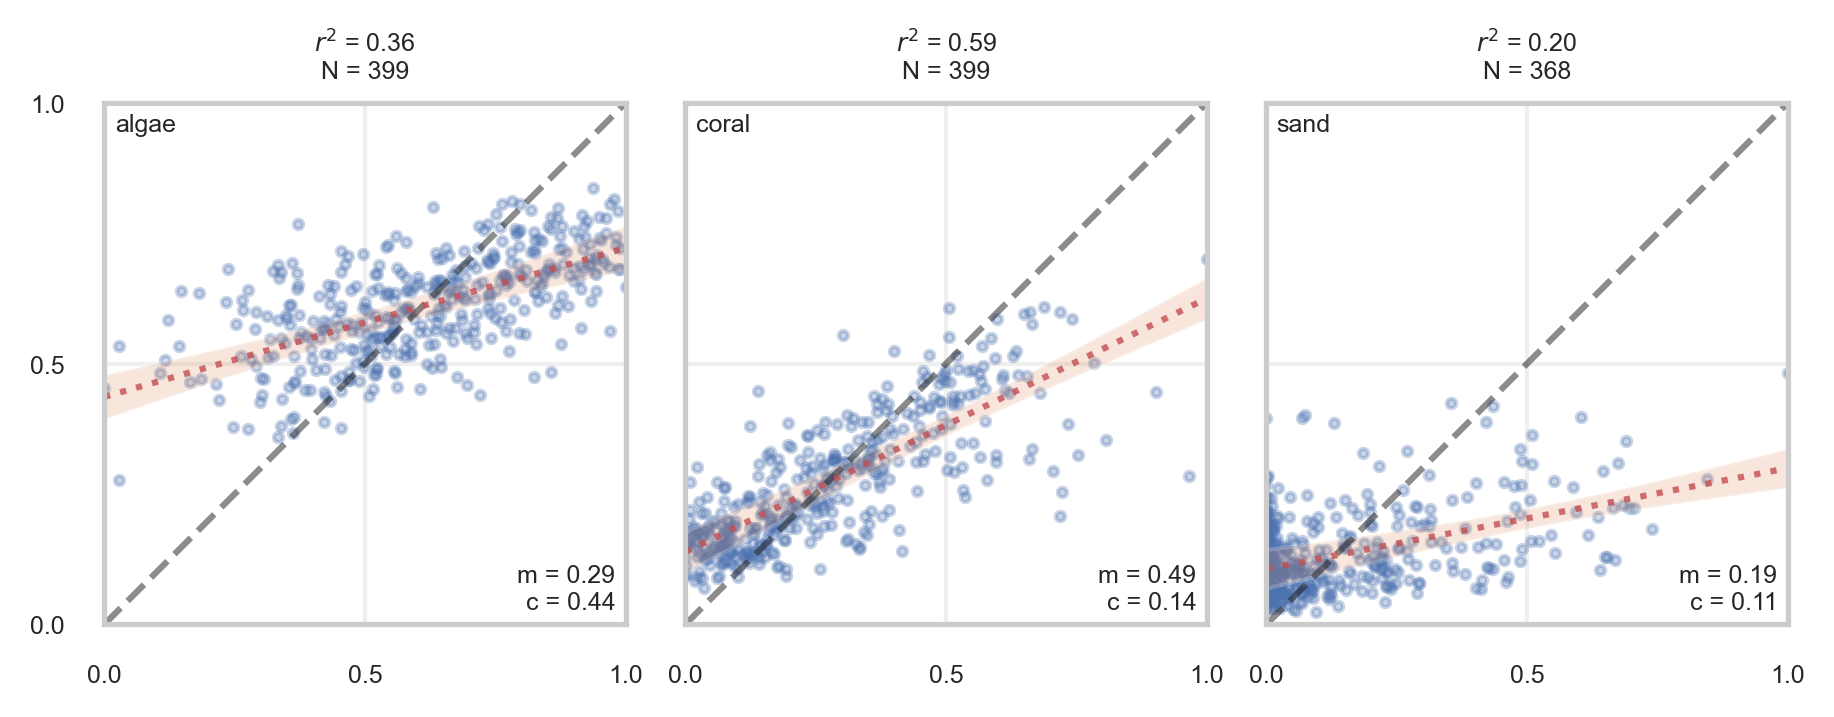

In [49]:
test_data = y_test
pred_data = y_pred_rf

plotting.plot_regression_results(test_data, pred_data, labels,
                                #  metadata=metadata,
                                 color_by="Depth")

In [ ]:
test_data = y_test
pred_data = y_pred_rf

plotting.plot_regression_results(test_data, pred_data, labels,
                                #  metadata=metadata,
                                 color_by="Depth")